 1. Construct a Social Network
 2. Define parameters and rules. Explain choice of values
 3. Implement an epidemic spread
 4. How will you incoporate quarantining in this network 
     - show impact of quarantining
 5. How will you implement vaccination in this network
     - show why your strategy is better than some other strategy

### Notes:
1. Covid $R_0$ = 2.5 (https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html)
2. Network to use = Watts-Strogatz. 
    - Need a small-world network with groups of high clustering coefficients to simulate families..
    - VS Erdos-Renyi: ER model doesn't take into account clustering coefficient and an ER model tends to be very low. Also, it doesn't closely simulate real-world networks as degree distribution doesn't follow power law.
    - VS Barabasi-Albert: 2nd best network to consider, as it takes into account hubs or super-spreaders in a network. For this epidemic modelling though, we won't need hubs. Just some random infected nodes.
3. Vaccination, what does it mean? Removing from network? or just in network but not `S` anymore? The answer: remove from network. **Lev, T., Shmueli, E. State-based targeted vaccination. Appl Netw Sci 6, 6 (2021). https://doi.org/10.1007/s41109-021-00352-z**
4. SIR model = https://guava.physics.uiuc.edu/~nigel/courses/563/Essays_2005/PDF/chen.pdf. For simplicity and for trying to replicate the characteristics of Covid, use SI model.
5. Python implementation https://python.plainenglish.io/visualizing-dynamic-phenomena-with-sir-model-and-networks-45a4e629e609
6. Vaccination - random, targeted, then state-based
7. Epidemics on Networks - https://arxiv.org/pdf/2001.02436.pdf

---

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import collections
import community
import EoN
from random import choice

# Epidemic Spread, Vaccination and Other Prevention Strategies: Modelling an Epidemic via Network Analysis

### Constructing a Social Network

The purpose of epidemic spread modelling is to analyze the structure of the epidemic network specifically how it travels from one person to another and how fast it travels. By identifying these things, we can identify superspreaders that largely affect the spread of disease. Given that vaccines are currently limited, we could specfiically formulate a strategy on how we would prioritize these people in implementing vaccination programs. 

**Watts-Strogatz Model**

For this simulation, we decided to use Watts-Strogatz to generate the social network mainly because of its two distinct properties:

1. The model generates a network with high clustering coefficient, which reflects how families within the community are connected.
2. The model also has a short characteristic path length, which reflects the behavior of interaction within a community.

We could use other models such as Erdős–Rényi and Barabási–Albert. However, we want to prioritize high clustering coefficient that reflects the families formed in communities, which is not present in both of these models. 

**Parameter Selection**

For the Watts-Strogatz Model, we need three parameters: the number of nodes (n), the number of nearest neighbors connected to each node (k), and the reconnection probability (p). 

For this simulation, we selected 100 as the size of community. We selected this to simulate a community of around 20 to 30 families. In terms of visualization, it's optimal since the network plots won't look too cluttered during our simulation.

For the number of nearest neighbors, we selected it to be 5. Although the average family size is 5, there are still households with people living alone or couples that are starting their family. We estimate the resulting average to be around 3. We added 1 to take into account the interaction generated from going out of the house.

For p, recall that we want to retain high average clustering coefficient with a short characteristic path length. To check a desirable value for p, we simulate different values of p given our n and k. 

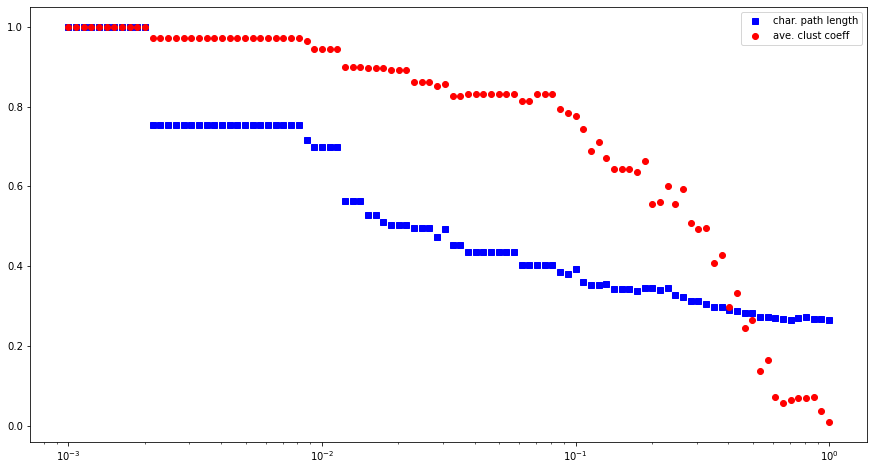

In [2]:
pvals = np.logspace(-3,0,100)
l_vals = []
c_vals = []
for p in pvals:
    G = nx.watts_strogatz_graph(n=100, k=4, p=p, seed=1)
    l_vals.append(nx.average_shortest_path_length(G))
    c_vals.append(nx.average_clustering(G))
l_vals_normed = [l/l_vals[0] for l in l_vals]
c_vals_normed = [c/c_vals[0] for c in c_vals]
plt.figure(figsize=(15,8))
plt.semilogx(pvals,l_vals_normed,'bs', label = "char. path length");
plt.semilogx(pvals,c_vals_normed, 'ro', label = "ave. clust coeff");
plt.legend();

Based on the plot, we can select a p that is slightly lower than 0.1. This is mainly because of the sharper drop in average clustering coefficient after 0.1. For this simulation, let's select p=0.09.

**Plotting the Network**

Now that we have our parameters for the network, let's look at the resulting network plot.

In [3]:
G = nx.watts_strogatz_graph(100, 4, 0.09, seed=1)

In [4]:
weights = [random.random() for weight in range(G.number_of_edges())]

norm_weights = [i/max(weights) for i in weights]

k=0
for i, j in G.edges():
    G[i][j]['weight'] = norm_weights[k]
    k+=1
    
edge_widths = [data['weight'] for (source, target, data) in G.edges(data=True)]


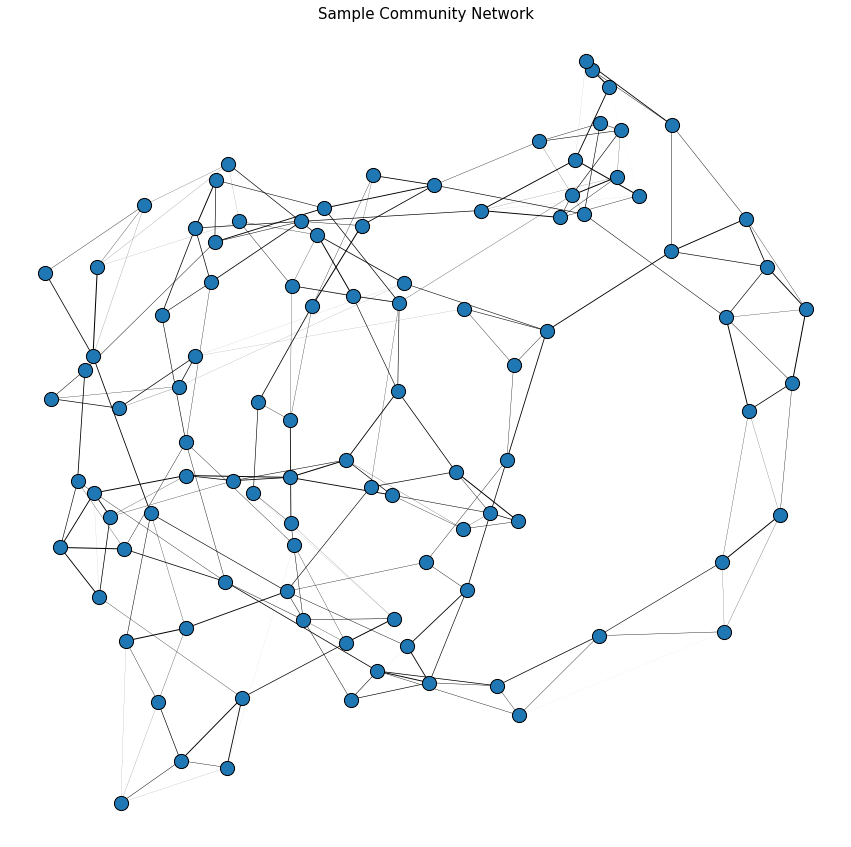

In [5]:
plt.figure(figsize=(15,15))
plt.axis('off')
pos = nx.spring_layout(G, k = 0.2, seed=1)
nx.draw_networkx(G, pos = pos, cmap = plt.cm.RdYlBu, 
                node_size = 200, with_labels = False, width = edge_widths)
ax = plt.gca()
ax.collections[0].set_edgecolor("black")

plt.title('Sample Community Network', size=15)
plt.show()

### Setting Infected People

In this step of the epidemic modeling, we initialize 10% of the population or the total nodes of the network to be infected at day zero of the simulation. This will be the start of our simulation and from here, we will observe how the disease travels from one person to another. As seen from the complex network graph, the infected people are labeled as the red nodes and their size is slightly bigger than those of the normal people, which are the blue nodes.

In [6]:
#Check node attributes
G.nodes(data=True)

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}, 52: {}, 53: {}, 54: {}, 55: {}, 56: {}, 57: {}, 58: {}, 59: {}, 60: {}, 61: {}, 62: {}, 63: {}, 64: {}, 65: {}, 66: {}, 67: {}, 68: {}, 69: {}, 70: {}, 71: {}, 72: {}, 73: {}, 74: {}, 75: {}, 76: {}, 77: {}, 78: {}, 79: {}, 80: {}, 81: {}, 82: {}, 83: {}, 84: {}, 85: {}, 86: {}, 87: {}, 88: {}, 89: {}, 90: {}, 91: {}, 92: {}, 93: {}, 94: {}, 95: {}, 96: {}, 97: {}, 98: {}, 99: {}})

In [7]:
nx.set_node_attributes(G, 0, 'S')
nx.set_node_attributes(G, 0, 'I')
nx.set_node_attributes(G, 0, 'R')
nx.set_node_attributes(G, 0, 'Q')
nx.set_node_attributes(G, 0, 'V')

In [8]:
for i in range(int(G.number_of_edges()*0.1)):
    G.nodes(data=True)[choice(list(G.nodes))]['I'] = 1

In [9]:
infected = sum([value for key, value in nx.get_node_attributes(G,'I').items()])

In [10]:
# print(there are {} infected people', infected)

In [11]:
#https://www.javaer101.com/en/article/12785882.html
node_color = []
node_size = []
for nodes in G.nodes(data=True):
    if nodes[1]['I'] == 1:
        node_color.append('#DC143C')
        node_size.append(200*2.5)
    else:
        node_color.append('#4169E1')
        node_size.append(200)

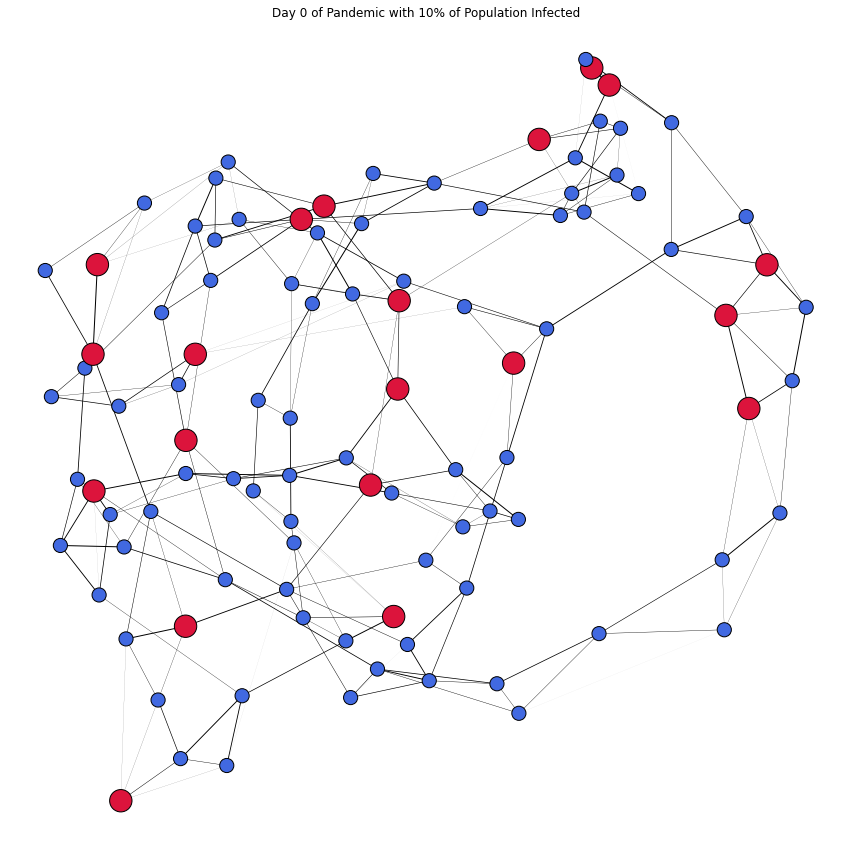

In [12]:
plt.figure(figsize=(15,15))
plt.axis('off')
pos = nx.spring_layout(G, k = 0.2, seed=1)
nx.draw_networkx(G, pos = pos, node_color=node_color, 
                node_size = node_size, with_labels = False, 
                 width = edge_widths)
ax = plt.gca()
ax.collections[0].set_edgecolor("black")

plt.title('Day 0 of Pandemic with 10% of Population Infected')
plt.show()

### Epidemic Spread

In this section, we simulate the spread of a highly contagious disease by initializing a rate of infection or the chance the person connected to another person might get infected. We chose the rate of infection similar to covid where 2 out of 3 people per individual has a chance of infection. In our code, we used a random function, and depending on the value it outputs, we set the connected person to be infected if that value is greater than 66.67%. This process will be implemented for all the people that are connected to an infected person in the next iterations.

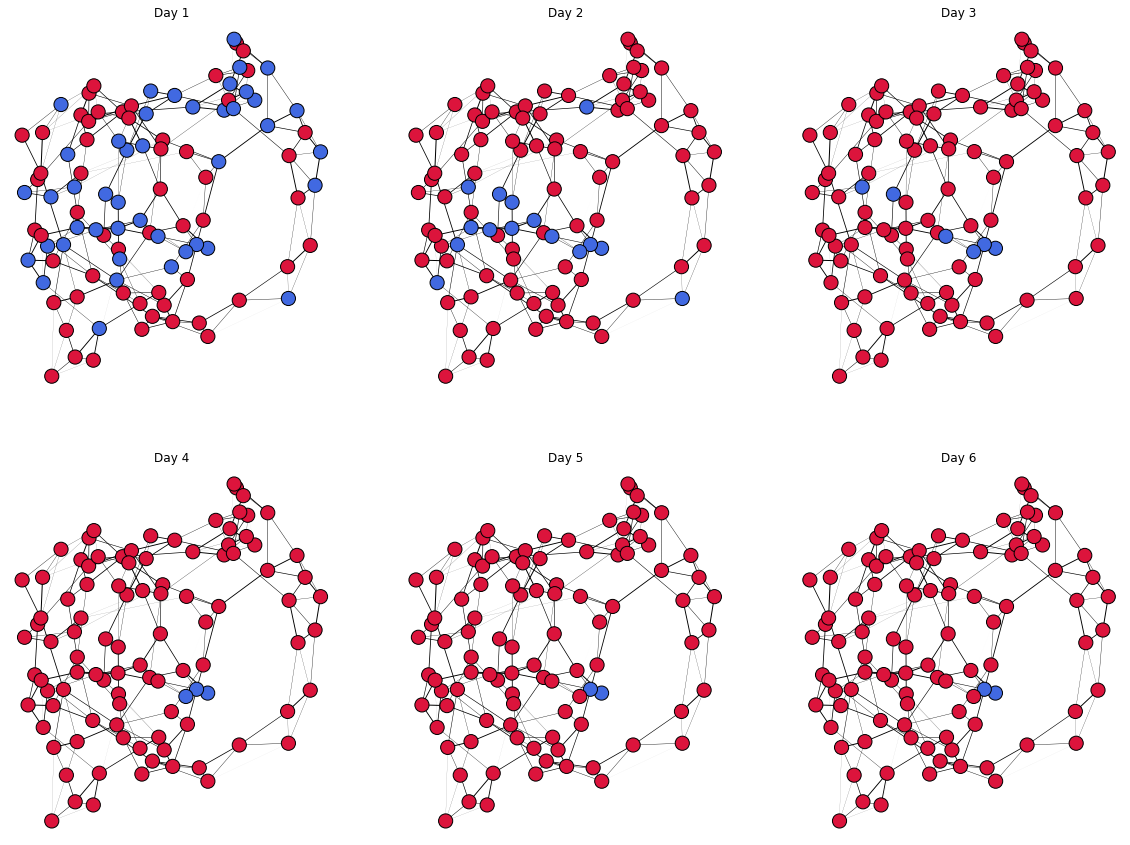

In [13]:
#https://github.com/eflegara/Network-Science-Lectures/blob/master/Exploring%20Social%20Distancing.ipynb
# pos = nx.spring_layout(G, k = 0.2, seed=1)
fig = plt.figure(figsize=(20,15));
G1 = G.copy()

initial = [infected]
# num_of_infected()

for i in range(6):
    for nodes in G1.nodes(data=True):
        if nodes[1]['I'] == 1:
            for edge in G1.edges(nodes[0]):
                if random.random() > (2/3):
                    G1.nodes(data=True)[edge[1]]['I'] = 1
                    
    initial.append((sum([value for key, value in 
                            nx.get_node_attributes(G1,'I').items()])))
    node_color = []
    node_size = []
    for nodes in G1.nodes(data=True):
        if nodes[1]['I'] == 1:
            node_color.append('#DC143C')
            node_size.append(200)
        else:
            node_color.append('#4169E1')
            node_size.append(200)


    ax = fig.add_subplot(2, 3, i+1);
    
    plt.axis('off')
    nc = nx.draw_networkx(G1, 
                     pos = pos, 
                     node_color=node_color, 
                     node_size = node_size, 
                     with_labels = False, 
                     width = edge_widths, 
                     )
    ax = plt.gca()
    ax.collections[0].set_edgecolor("black")

    plt.title('Day {}'.format(i+1))
plt.savefig('epidemics.jpg')
plt.show()

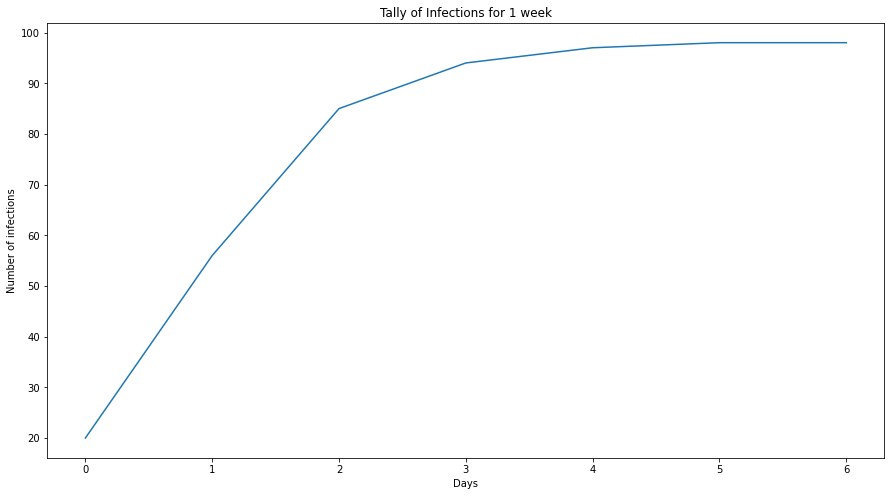

In [14]:
plt.figure(figsize=(15,8))
sns.lineplot(x=range(len(initial)), y=initial)
plt.xlabel('Days')
plt.ylabel('Number of infections')
plt.title('Tally of Infections for 1 week');

Based on the Tally of Infections fro 1 week graph above, we can see that the number of infections increases linearly from day zero until day two, and from there, the rate of infection slightly decreased on day three and day four, and by day five, all of the nodes have already been affected. We can see how fast the entire population can be infected even if there are only 10% of the total people that are initially infected.

### Quarantine

Quarantine is where we isolate a suspected infected person from the rest of the crowd. This is a safety precaution so that the disease will not spread further into other people, which can potentially spread into other networks if not stopped. For this implementation, once a node is identified to be infected, we would set that node to be under quarantine, but there is still a chance to infection. However, in the next iteration or next sequence, the quarantined individuals or nodes will now have 0% chance to infect the people connected to their network.

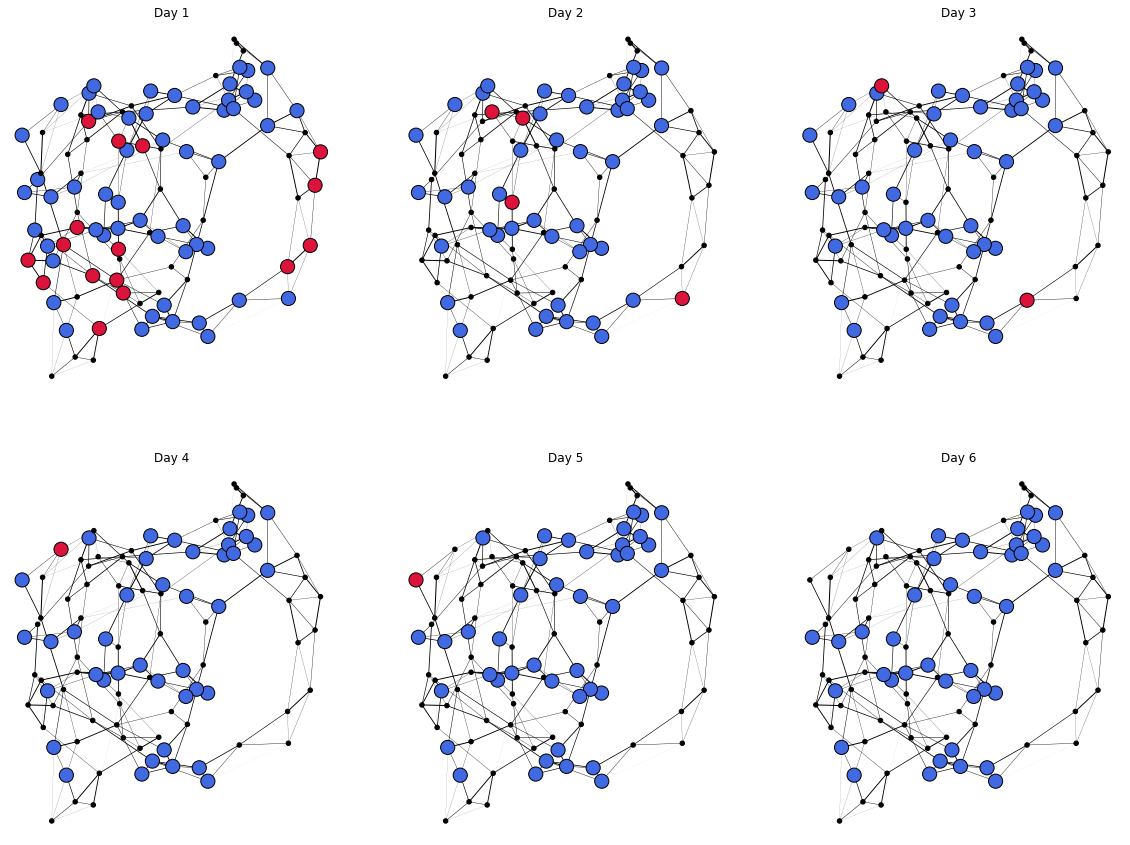

In [15]:
#https://github.com/eflegara/Network-Science-Lectures/blob/master/Exploring%20Social%20Distancing.ipynb
# pos = nx.spring_layout(G, k = 0.2, seed=1)
fig = plt.figure(figsize=(20,15));
G2 = G.copy()
q_initial = [infected]
quarantined = [0]
pos1 = nx.spring_layout(G2, k = 0.2, seed=1)

for i in range(6):
    for nodes in G2.nodes(data=True):
        if nodes[1]['I'] == 1:
            if nodes[1]['Q'] == 0:
                for edge in G2.edges(nodes[0]):
                    if random.random() > 0.66:
                        G2.nodes(data=True)[edge[1]]['I'] = 1
            G2.nodes(data=True)[nodes[0]]['Q'] = 1 
            G2.nodes(data=True)[nodes[0]]['I'] = 0 
                
    q_initial.append((sum([value for key, value in 
                            nx.get_node_attributes(G2,'I').items()])))
                
    quarantined.append((sum([value for key, value in 
                            nx.get_node_attributes(G2,'Q').items()])))
    
    
    node_color = []
    node_size = []
    for nodes in G2.nodes(data=True):
        if nodes[1]['Q'] == 1:
            node_color.append('black')
            node_size.append(20)
        elif nodes[1]['R'] == 1:
            node_color.append('green')
            node_size.append(200)
        elif nodes[1]['I'] == 1:
            node_color.append('#DC143C')
            node_size.append(200)
        else:
            node_color.append('#4169E1')
            node_size.append(200)
#         print(nodes)
    ax = fig.add_subplot(2, 3, i+1);
    
    plt.axis('off')
    nc = nx.draw_networkx(G2, 
                     pos = pos1, 
                     node_color=node_color, 
                     node_size = node_size, 
                     with_labels = False, 
                     width = edge_widths 
                     )
    ax = plt.gca()
    ax.collections[0].set_edgecolor("black")
    plt.title('Day {}'.format(i+1))
plt.show()

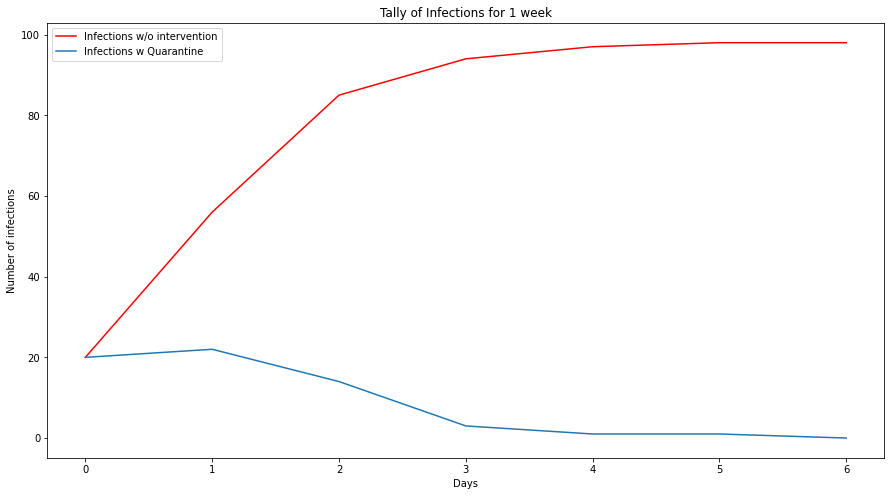

In [16]:
plt.figure(figsize=(15,8))

sns.lineplot(x=range(len(initial)), 
             y=initial, 
             label = 'Infections w/o intervention', 
             color = 'red')

sns.lineplot(x=range(len(q_initial)), 
             y=q_initial, 
             label = 'Infections w Quarantine')


plt.xlabel('Days')
plt.ylabel('Number of infections')
plt.legend()
plt.title('Tally of Infections for 1 week');

Looking at the same graph of tally of infections for 1 week, but this time we will compare the number of inections that we have when we implemented quarantine versus when we do not implement any intervention at all. We can see that the graph without the intervention increases linearly until everyone in the complex network is infected. Contrary to this, when we implement quarantine protocols, it can be observed that after an increase of infections from day zero to day one, the number of infection never went up anymore, instead, it gradually decreased until there are no people infecte anymore at the end of day five.

### Vaccination

### 1. Random Vaccination (Selecting Random Nodes to Vaccinate)
#### Vaccine with 98% efficacy.

*Explanation*
- Pfizer vaccine, 98% efficacy. Used in this simulation

In [17]:
#https://github.com/eflegara/Network-Science-Lectures/blob/master/Exploring%20Social%20Distancing.ipynb
# pos = nx.spring_layout(G, k = 0.2, seed=1)

def random_vacc(num):
    '''
    Create vaccination simulation
    
    Parameters:
    num : float
        percentage of people vaccinated
    '''
    fig = plt.figure(figsize=(20,15));

    H = G.copy()

    for i in range(int(H.number_of_edges()*num)):
        H.nodes(data=True)[choice(list(G.nodes))]['V'] = 1

    G3 = H.copy()

    initial = [infected]
    vaccinated = [0]
    not_infected = [0]
    # num_of_infected()

    for i in range(6):

        for nodes in G3.nodes(data=True):
            if nodes[1]['I'] == 1:
                for edge in G3.edges(nodes[0]):
                    if (G3.nodes(data=True)[edge[1]]['V'] == 1):
                        if random.random() > 0.98:
                            G3.nodes(data=True)[edge[1]]['I'] = 1
                    else:
                        if random.random() >= 0.66:
                            G3.nodes(data=True)[edge[1]]['I'] = 1


        initial.append((sum([value for key, value in 
                                nx.get_node_attributes(G3,'I').items()])))
        vaccinated.append((sum([value for key, value in 
                                nx.get_node_attributes(G3,'V').items()])))
        not_infected.append((100 - sum([value for key, value in 
                                nx.get_node_attributes(G3,'I').items()])))


        node_color = []
        node_size = []
        for nodes in G3.nodes(data=True):
            if nodes[1]['V'] == 1:
                node_color.append('green')
                node_size.append(100)
            elif nodes[1]['I'] == 1:
                node_color.append('#DC143C')
                node_size.append(200)
            else:
                node_color.append('#4169E1')
                node_size.append(200)


        ax = fig.add_subplot(2, 3, i+1);

        plt.axis('off')
        nc = nx.draw_networkx(G3, 
                         pos = pos, 
                         node_color=node_color, 
                         node_size = node_size, 
                         with_labels = False, 
                         width = edge_widths, 
                         )
        ax = plt.gca()
        ax.collections[0].set_edgecolor("black")

        plt.title('Day {}'.format(i+1))
    plt.savefig('epidemics.jpg')
    plt.show()
    return initial, vaccinated, not_infected

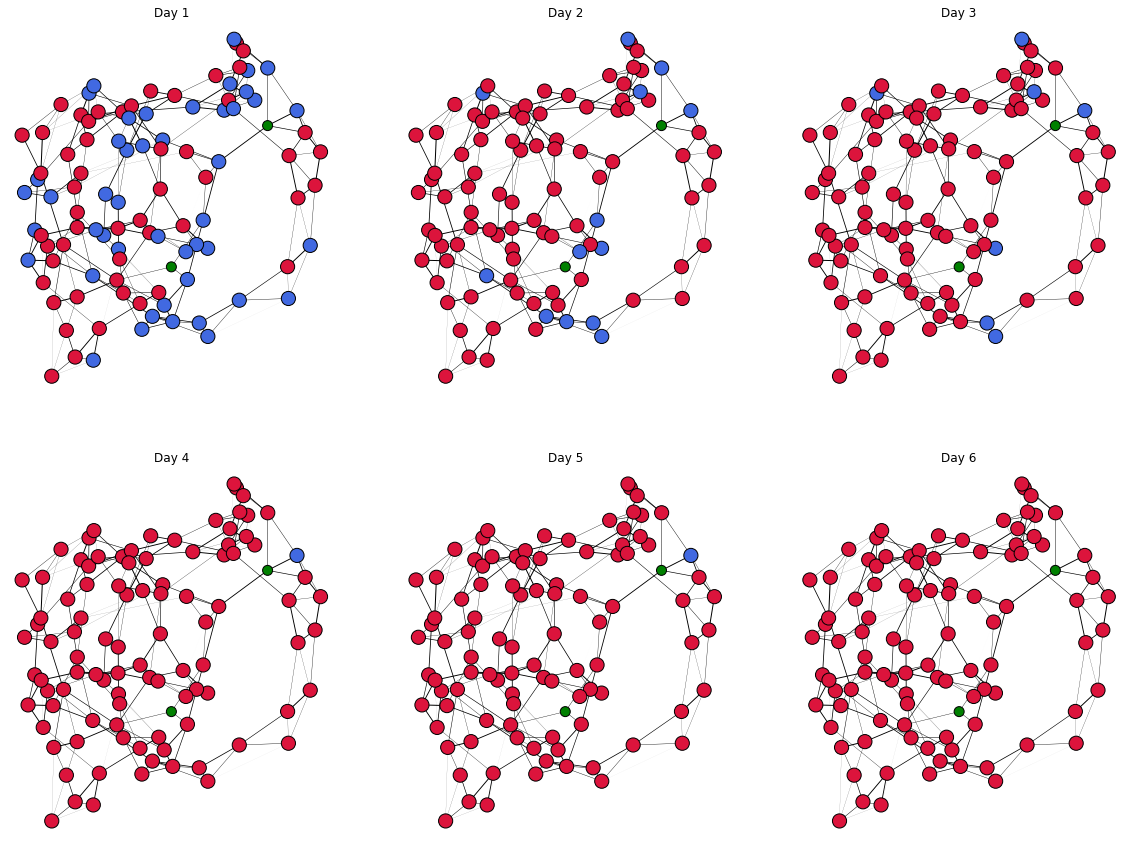

In [18]:
i1, v1, n1 = random_vacc(0.01)

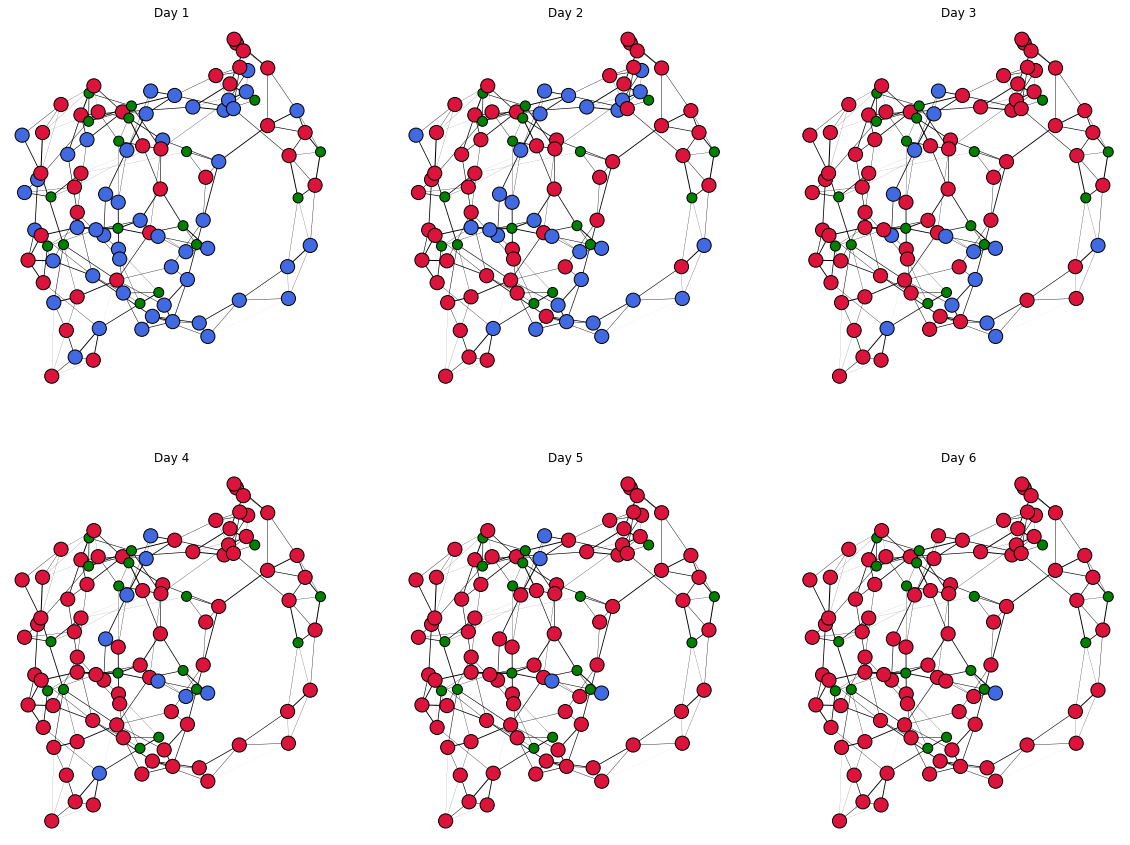

In [19]:
i2, v2, n2 = random_vacc(0.1)

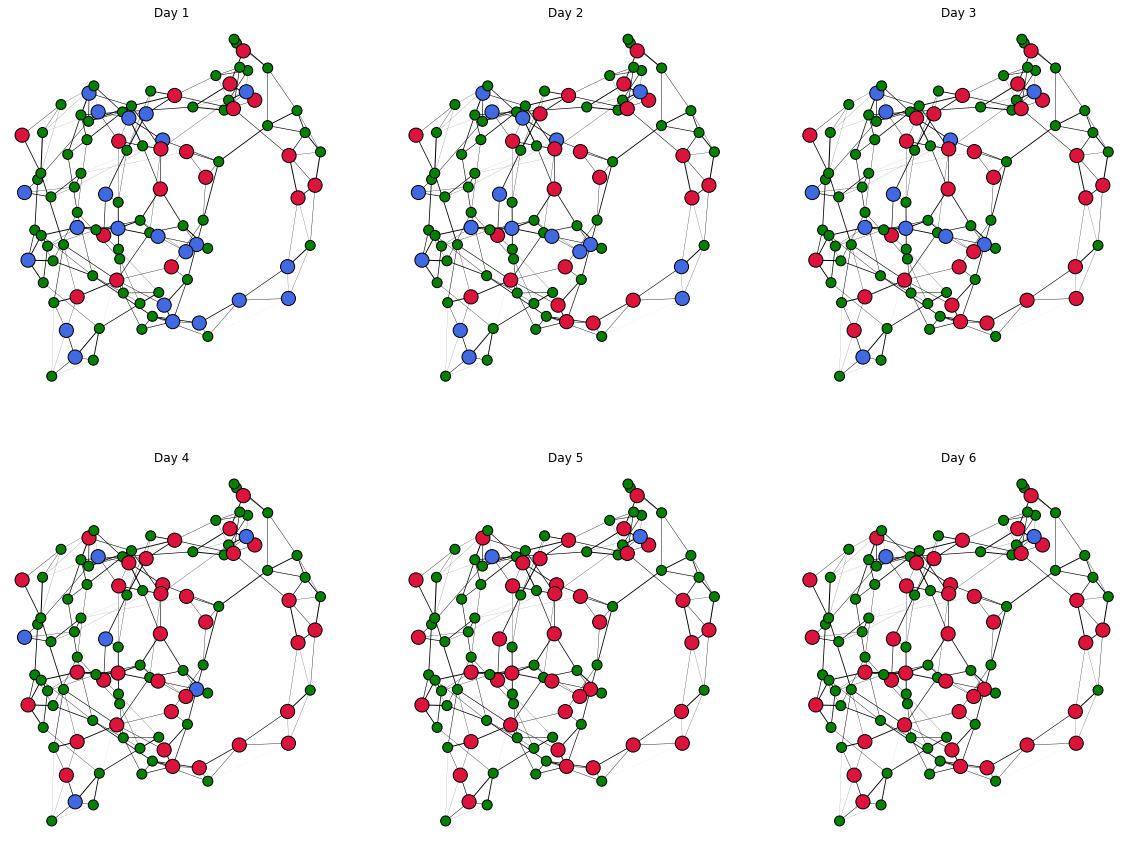

In [20]:
i3, v3, n3 = random_vacc(0.5)

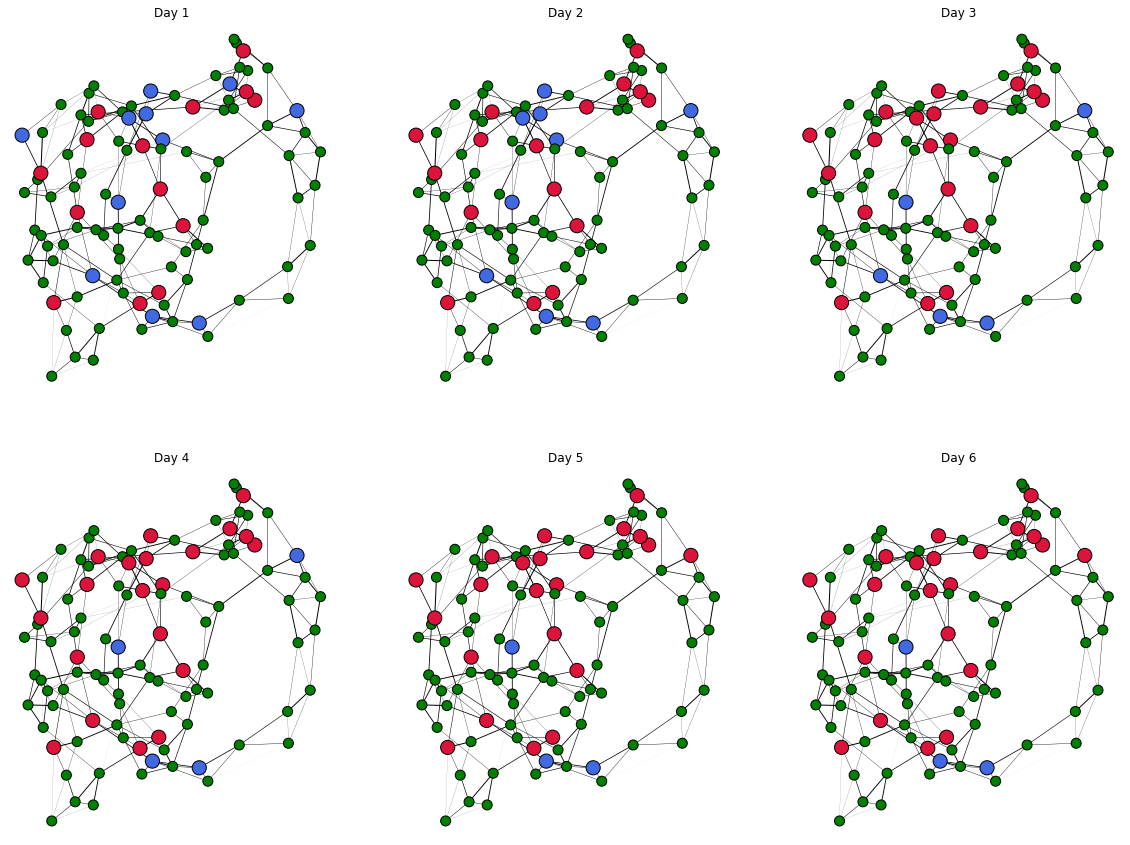

In [21]:
i4, v4, n4 = random_vacc(0.8)

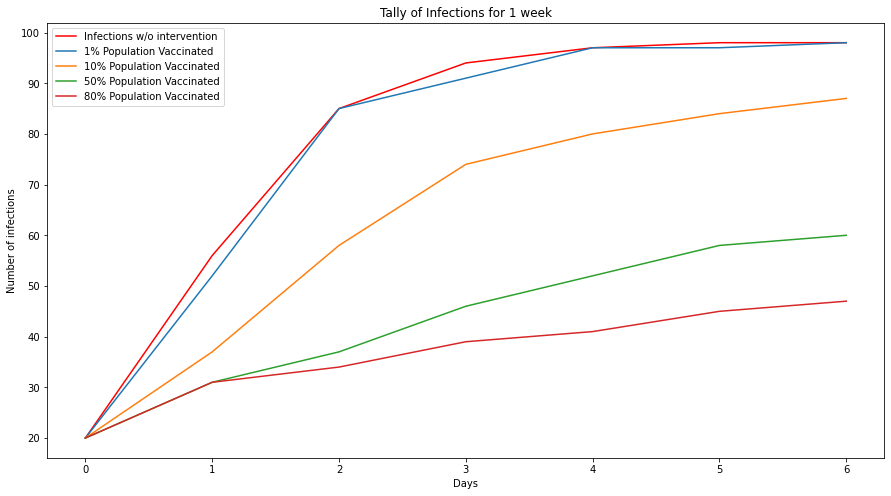

In [22]:
plt.figure(figsize=(15,8))

sns.lineplot(x=range(len(initial)), 
             y=initial, 
             label = 'Infections w/o intervention', 
             color = 'red')

sns.lineplot(x=range(len(i1)), 
             y=i1, 
             label = '1% Population Vaccinated')

sns.lineplot(x=range(len(i2)), 
             y=i2, 
             label = '10% Population Vaccinated')


sns.lineplot(x=range(len(i3)), 
             y=i3, 
             label = '50% Population Vaccinated')


sns.lineplot(x=range(len(i4)), 
             y=i4, 
             label = '80% Population Vaccinated')


plt.xlabel('Days')
plt.ylabel('Number of infections')
plt.legend()
plt.title('Tally of Infections for 1 week');

Looking at this graph of 1 week tally of infections, we differentiate the effect of the percentage of population vaccinated in the inrease in the number of infections. As expected, we can see that the lower the percentage of the population vaccinate, the fast the rate of infection is. However, looking at the graph of 1% vaccinated population, it has a faster rate of infection compared to no intervention from day zero until day three, and has a lower rate of infection from day three onwards, but the difference of the rate of infection does not matter as they both reach the peak of everyone getting infected.

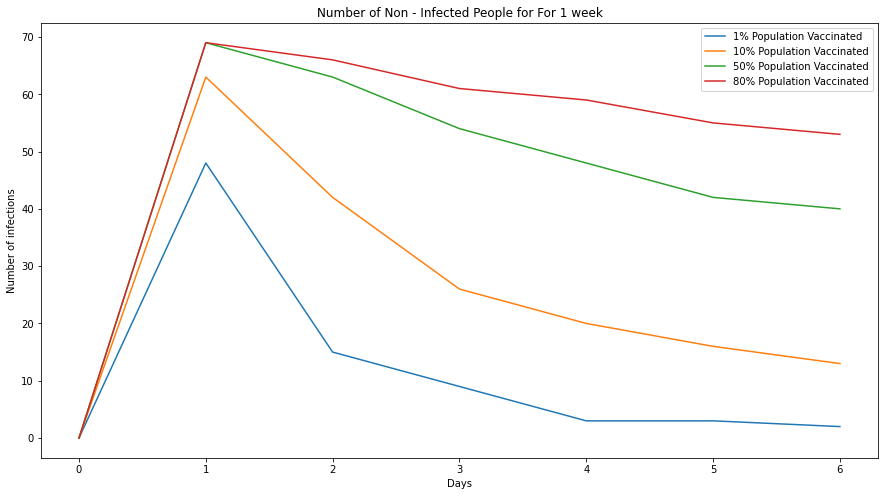

In [23]:
plt.figure(figsize=(15,8))

sns.lineplot(x=range(len(n1)), 
             y=n1, 
             label = '1% Population Vaccinated')

sns.lineplot(x=range(len(n2)), 
             y=n2, 
             label = '10% Population Vaccinated')


sns.lineplot(x=range(len(n3)), 
             y=n3, 
             label = '50% Population Vaccinated')


sns.lineplot(x=range(len(n4)), 
             y=n4, 
             label = '80% Population Vaccinated')


plt.xlabel('Days')
plt.ylabel('Number of infections')
plt.legend()
plt.title('Number of Non - Infected People for For 1 week');

*Explanation about graph*

### Targeted Vaccination

*Explanation*
- chosen nodes are vaccinated.
- chosen nodes based on closeness centrality. Why? Closeness centrality is the reciprocal sum of shortest distances to the node. degree centrality is not used because it is a random network built on at least 3 nodes. so each node will have either 2 or 3 edges. Eigenvector and betweenness have low value

In [24]:
degree = list(nx.degree_centrality(G).values())
closeness = list(nx.closeness_centrality(G).values())
betweenness = list(nx.betweenness_centrality(G).values())
eigenvector = list(nx.nx.eigenvector_centrality_numpy(G).values())

In [25]:
centralities = [degree, closeness, betweenness, eigenvector]

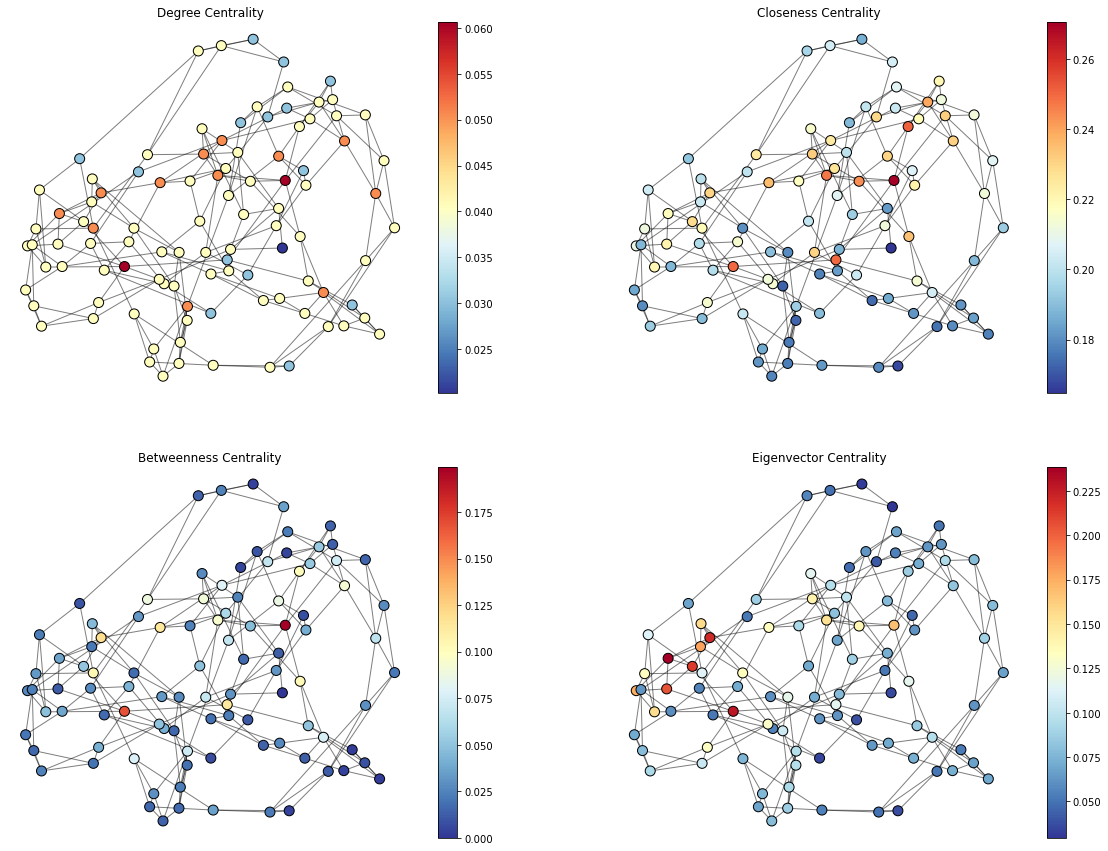

In [26]:
fig = plt.figure(figsize=(20,15));

titles = ['Degree Centrality', 'Closeness Centrality', 
          'Betweenness Centrality', 'Eigenvector Centrality']

pos = nx.spring_layout(G, k=0.18)

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1);
    nc = nx.draw_networkx_nodes(G, pos, 
                            node_size=100, cmap=plt.cm.RdYlBu_r,
                            node_color=centralities[i]);
    nx.draw_networkx_edges(G, pos, alpha=0.500);
    plt.title(titles[i]);
    plt.axis('off');
    plt.colorbar(nc);
    
    ax = plt.gca()
    ax.collections[0].set_edgecolor("black")

plt.show()

In [27]:
#https://github.com/eflegara/Network-Science-Lectures/blob/master/Exploring%20Social%20Distancing.ipynb
# pos = nx.spring_layout(G, k = 0.2, seed=1)

def choice_vacc(num):
    '''
    Create vaccination simulation based on closeness centrality
    
    Parameters:
    num : int
        number of people vaccinated based on closeness centrality
    '''
    fig = plt.figure(figsize=(20,15));

    H = G.copy()
    top = list(sorted(nx.closeness_centrality(H).items(), 
                     key=lambda x: -x[1]))[:num]
    top = [i[0] for i in top]
    
    for i in top:
        H.nodes(data=True)[i]['V'] = 1

    G3 = H.copy()

    initial = [infected]
    vaccinated = [0]
    not_infected = [0]
    # num_of_infected()

    for i in range(6):

        for nodes in G3.nodes(data=True):
            if nodes[1]['I'] == 1:
                for edge in G3.edges(nodes[0]):
                    if (G3.nodes(data=True)[edge[1]]['V'] == 1):
                        if random.random() > 0.98:
                            G3.nodes(data=True)[edge[1]]['I'] = 1
                    else:
                        if random.random() >= 0.66:
                            G3.nodes(data=True)[edge[1]]['I'] = 1


        initial.append((sum([value for key, value in 
                                nx.get_node_attributes(G3,'I').items()])))
        vaccinated.append((sum([value for key, value in 
                                nx.get_node_attributes(G3,'V').items()])))
        not_infected.append((100 - sum([value for key, value in 
                                nx.get_node_attributes(G3,'I').items()])))


        node_color = []
        node_size = []
        for nodes in G3.nodes(data=True):
            if nodes[1]['V'] == 1:
                node_color.append('green')
                node_size.append(100)
            elif nodes[1]['I'] == 1:
                node_color.append('#DC143C')
                node_size.append(200)
            else:
                node_color.append('#4169E1')
                node_size.append(200)


        ax = fig.add_subplot(2, 3, i+1);

        plt.axis('off')
        nc = nx.draw_networkx(G3, 
                         pos = pos, 
                         node_color=node_color, 
                         node_size = node_size, 
                         with_labels = False, 
                         width = edge_widths, 
                         )
        ax = plt.gca()
        ax.collections[0].set_edgecolor("black")

        plt.title('Day {}'.format(i+1))
    plt.savefig('epidemics.jpg')
    plt.show()
    return initial, vaccinated, not_infected

#### Top 10 Nodes Based on Closeness Centrality

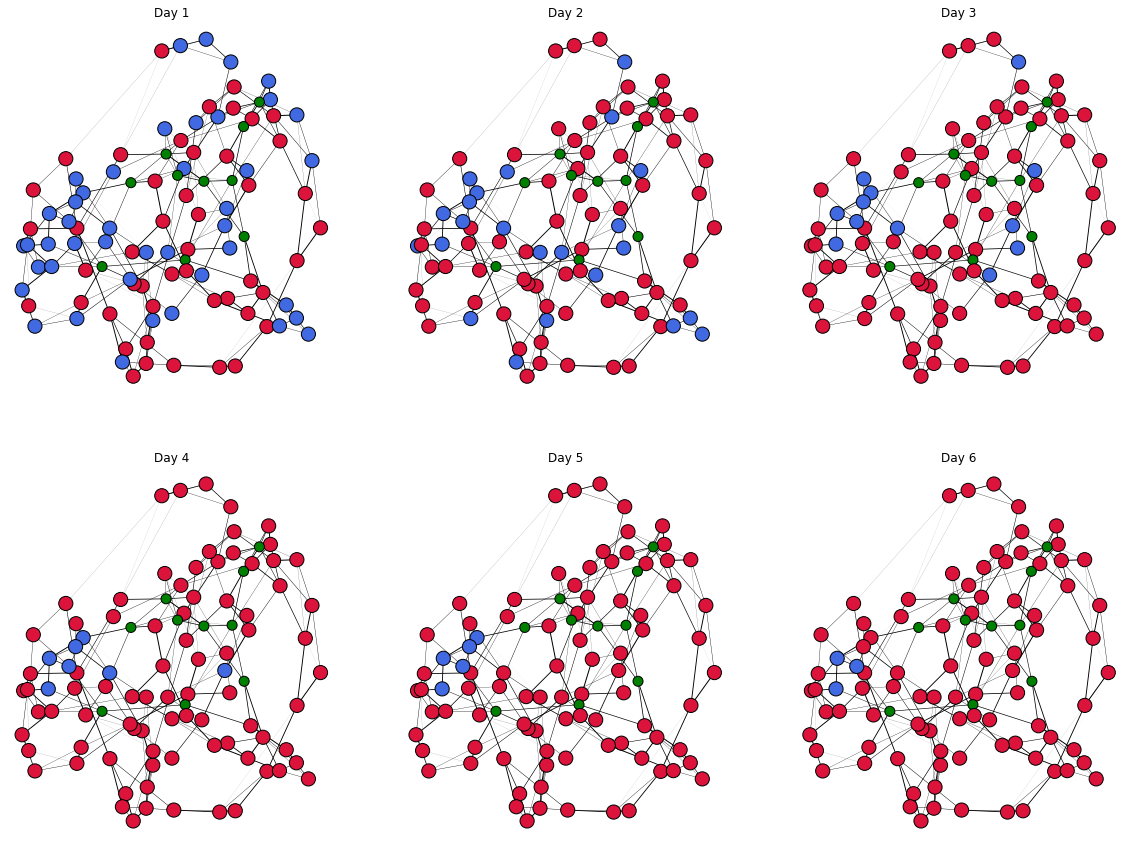

In [28]:
ci1, cv1, cn1 = choice_vacc(10)

#### Top 20 Nodes Based on Closeness Centrality

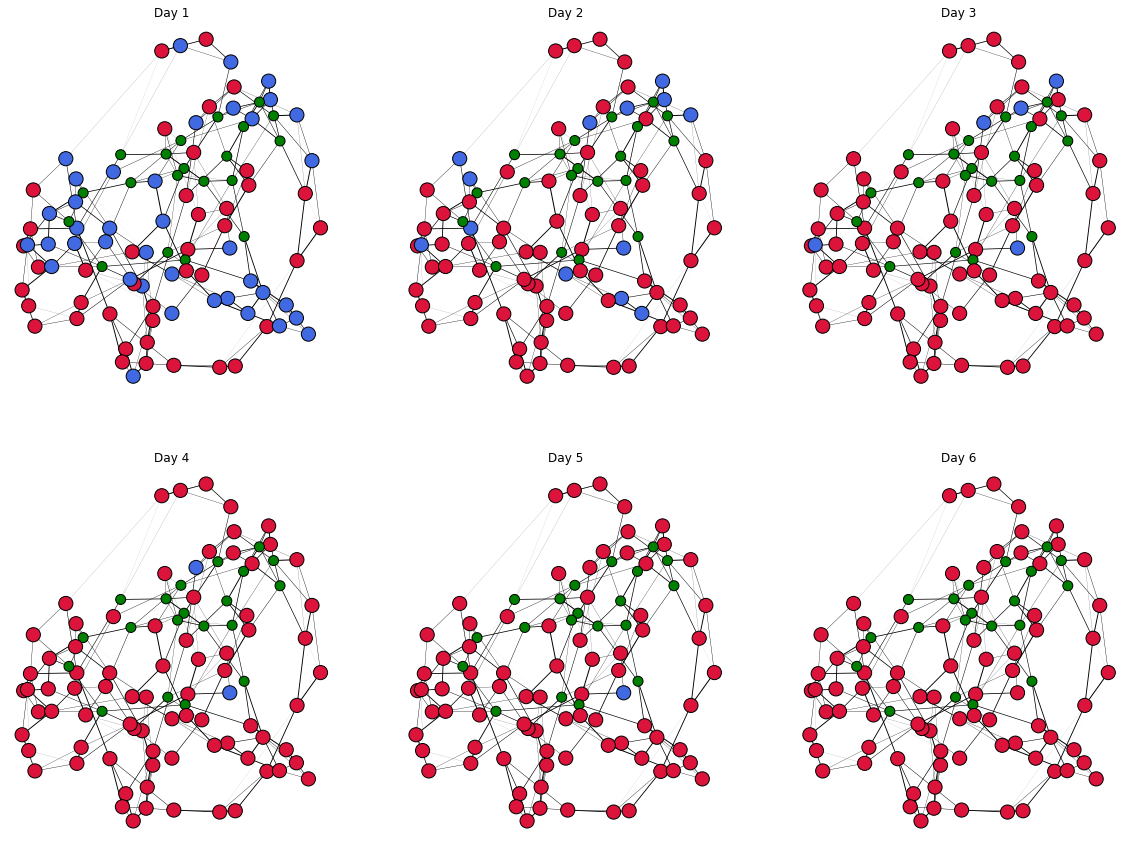

In [29]:
ci2, cv2, cn2 = choice_vacc(20)

#### Top 40 Nodes Based on Closeness Centrality

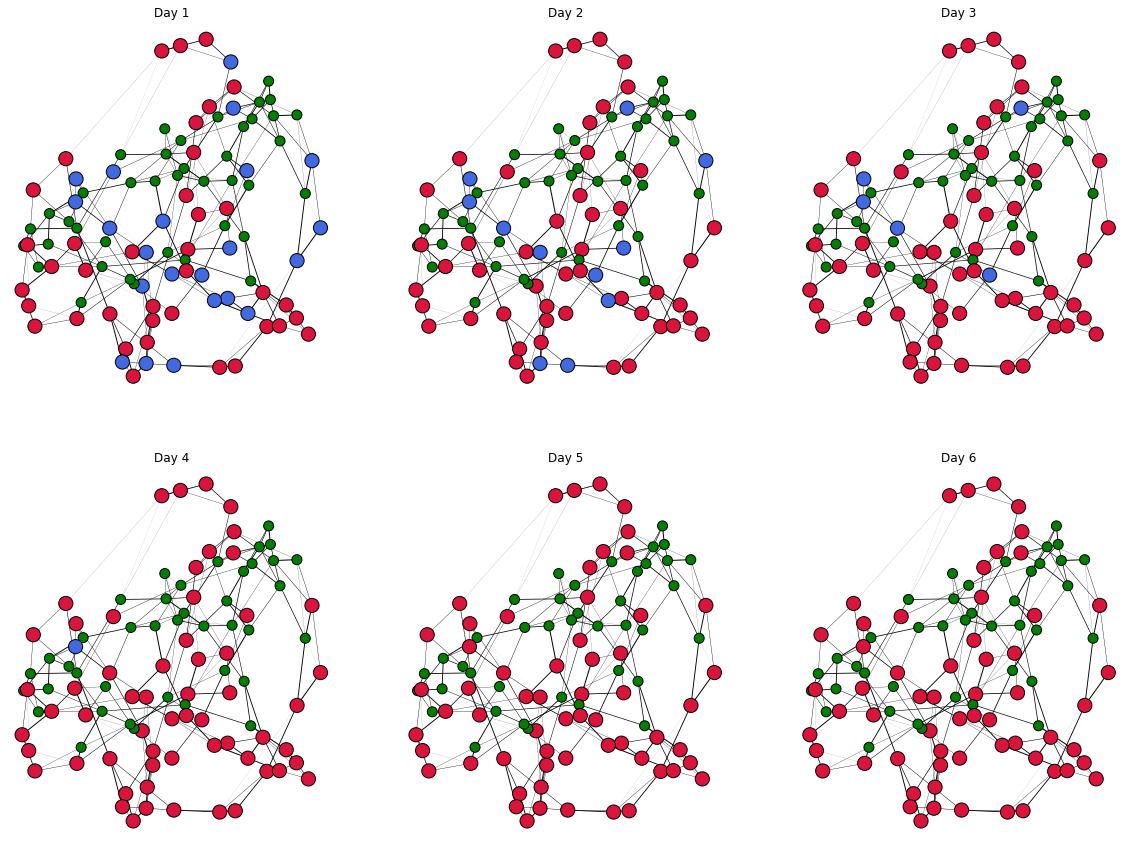

In [30]:
ci3, cv3, cn3 = choice_vacc(40)

#### Top 60 Nodes Based on Closeness Centrality

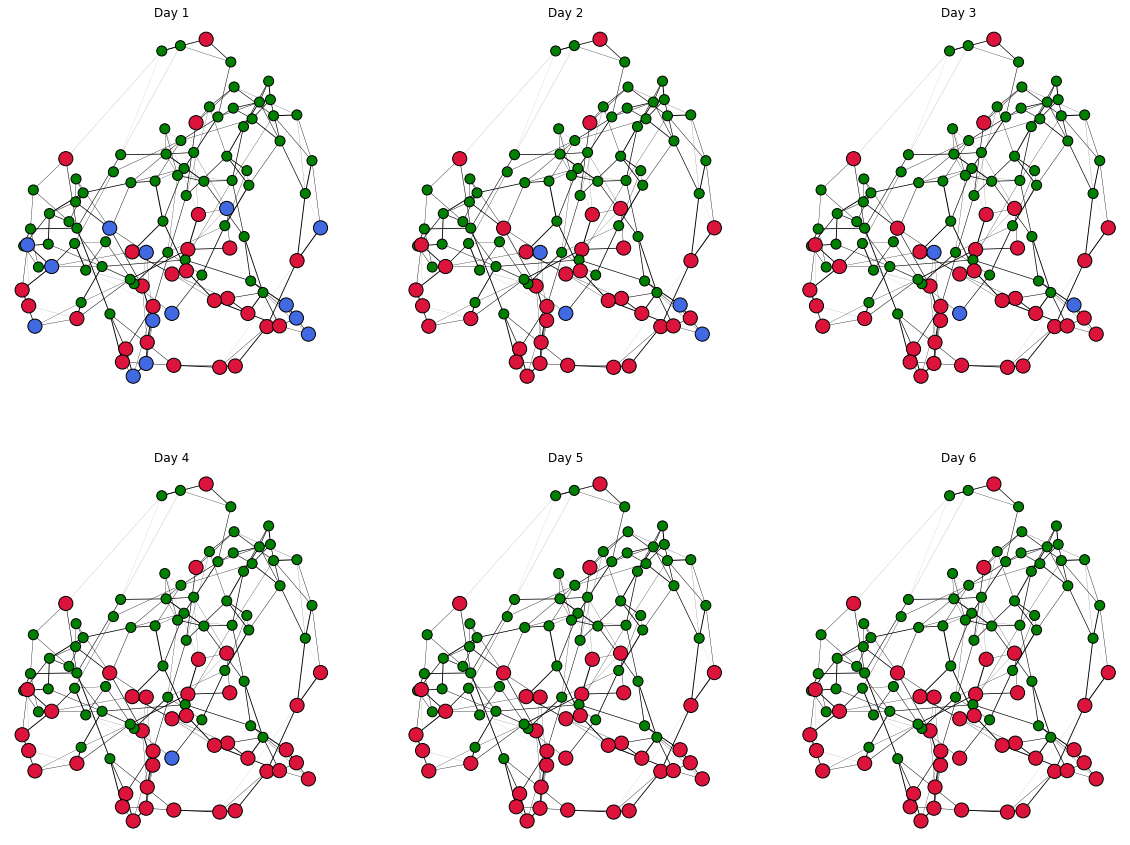

In [31]:
ci4, cv4, cn4 = choice_vacc(60)

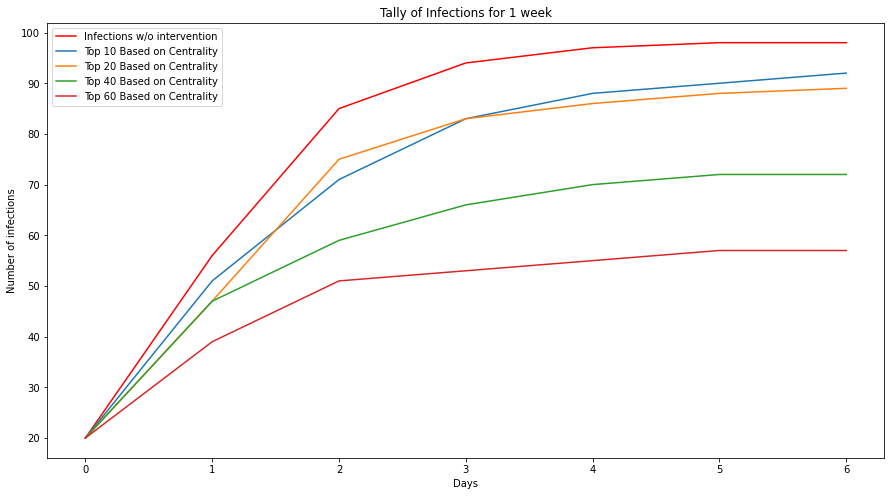

In [32]:
plt.figure(figsize=(15,8))

sns.lineplot(x=range(len(initial)), 
             y=initial, 
             label = 'Infections w/o intervention', 
             color = 'red')

sns.lineplot(x=range(len(ci1)), 
             y=ci1, 
             label = 'Top 10 Based on Centrality')

sns.lineplot(x=range(len(ci2)), 
             y=ci2, 
             label = 'Top 20 Based on Centrality')


sns.lineplot(x=range(len(ci3)), 
             y=ci3, 
             label = 'Top 40 Based on Centrality')


sns.lineplot(x=range(len(ci4)), 
             y=ci4, 
             label = 'Top 60 Based on Centrality')


plt.xlabel('Days')
plt.ylabel('Number of infections')
plt.legend()
plt.title('Tally of Infections for 1 week');

In this graph, we compared the different number of people who are targeted to have initial vaccines based on centrality before we start the simulation. As expected, the higher the number of people who are initially givene vaccines, the lower the rate of infection is, and the lower the number of people who are infected by the time we reach day six.

### Appendix: Epidemic Spread Simulation via EoN (Epidemics on Networks) Library

<Figure size 1080x1440 with 0 Axes>

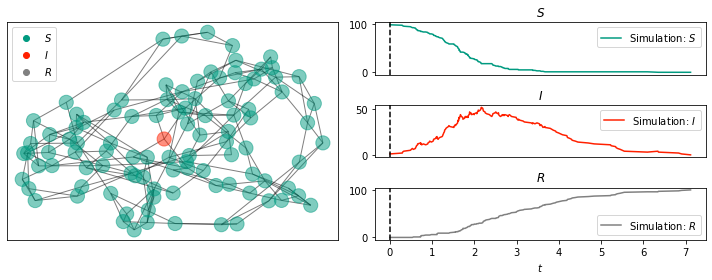

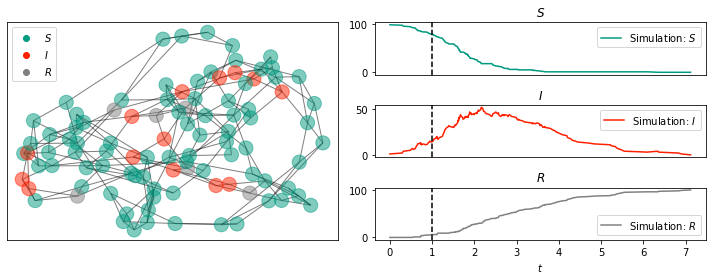

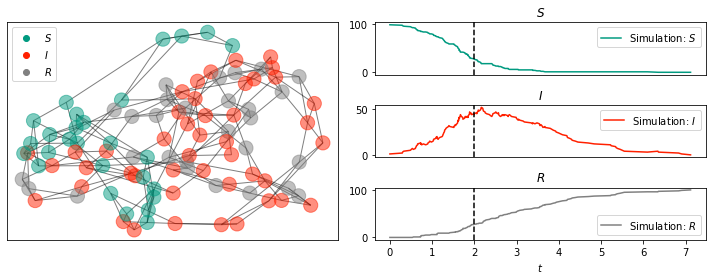

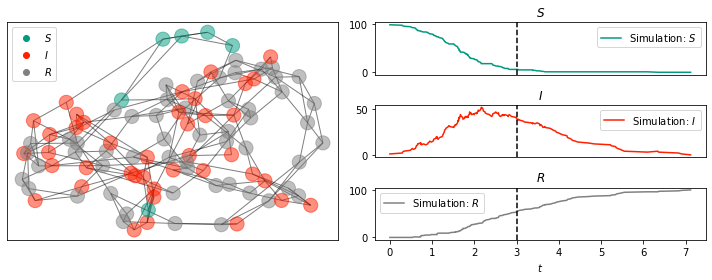

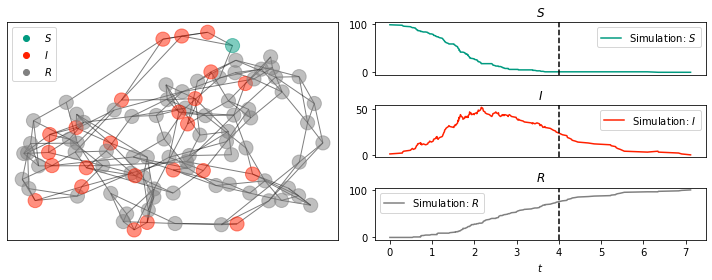

In [33]:
tau = 2
gamma = 0.8

simulation = EoN.fast_SIR(G, tau, gamma, initial_infecteds = 1, 
                         return_full_data = True)

nx_kwargs = {
    'pos':pos,
    'node_size': 200, 
    'alpha': 0.5
}
plt.figure(figsize=(15, 20))
# nx_kwargs = {"pos": pos, "alpha": 0.7}

for i in range(0, 5):
    ax = simulation.display(time = i, **nx_kwargs)
